In [59]:
import sys
sys.path.insert(1, '../../scripts/')
from s3_support import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load data

In [6]:
q = '''select 
            form,
            date_trunc('week', date) as week,
            sum(views) as views
        from ga 
        where 
            form!=0 and date>='2019-01-01' 
        group by form, date_trunc('week', date)'''
traff = redshift_query_read(q, schema='production')

In [123]:
print("{:,} observations".format(len(traff)))
print("{:,} forms".format(len(traff['form'].unique())))
print("{} to {}".format(traff['week'].min(), traff['week'].max()))

1,398,782 observations
64,560 forms
2018-12-31 00:00:00 to 2024-02-26 00:00:00


In [121]:
q = '''select
            form,
            date_trunc('week', date) as week,
            count(id) as trans_count,
            sum(amount) as trans_vol,
            count(distinct(case when recurring=0 then id else null end)) as trans_onetime_count,
            sum(case when recurring=0 then amount else null end) as trans_onetime_vol,
            count(distinct(case when recurring_origin!=0 and recurring!=0 then id else null end)) as trans_rec_count,
            sum(case when recurring_origin!=0 and recurring!=0 then amount else null end) as trans_rec_vol
        from transactions
        where status='A' and year >= 2019 and source != 'vt' and source != 'mobilevt'
        group by form, date_trunc('week', date)'''
trans = redshift_query_read(q, schema='production')

In [122]:
print("{:,} observations".format(len(trans)))
print("{:,} forms".format(len(trans['form'].unique())))
print("{} to {}".format(trans['week'].min(), trans['week'].max()))

1,054,057 observations
48,172 forms
2018-12-31 00:00:00 to 2024-03-18 00:00:00


## merge

In [124]:
df = trans.merge(traff, on=['form', 'week'])

In [125]:
print("{:,} observations".format(len(df)))
print("{:,} forms".format(len(df['form'].unique())))
print("{} to {}".format(df['week'].min(), df['week'].max()))

545,262 observations
37,602 forms
2018-12-31 00:00:00 to 2024-02-26 00:00:00


# analysis

We want to identify an average sample of forms that match the middle group of all forms by the following metrics:

1. traffic
2. processing volume
3. One time / recurring ratio
4. Average transaction value

In [126]:
df.drop(['form', 'week'], axis=1).describe()

,trans_count,trans_vol,trans_onetime_count,trans_onetime_vol,trans_rec_count,trans_rec_vol,views
count,545262.000000,5.452620e+05,545262.000000,4.328510e+05,545262.000000,72311.000000,545262.000000
mean,16.780436,2.103694e+03,10.729609,2.195667e+03,0.392564,290.531239,144.958229
std,102.499524,9.758638e+03,64.581249,9.721838e+03,7.348685,2021.435653,1120.935623
min,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.010000,0.000000
25%,2.000000,1.000000e+02,1.000000,1.000000e+02,0.000000,26.000000,7.000000
50%,4.000000,3.800000e+02,2.000000,4.202500e+02,0.000000,67.600000,22.000000
75%,11.000000,1.457043e+03,7.000000,1.550000e+03,0.000000,167.220000,78.000000
max,29171.000000,1.750986e+06,23638.000000,1.726593e+06,2978.000000,192815.240000,238870.000000


In [127]:
(df==0).sum()

form                        0
week                        0
trans_count                 0
trans_vol               20508
trans_onetime_count    112411
trans_onetime_vol       23709
trans_rec_count        472951
trans_rec_vol               0
views                    1378
dtype: int64

## 1. traffic

Start with how common it is to have a 0 page view day

In [128]:
df.groupby('form')['views'].agg(['mean', 'median']).mean()

mean      135.023732
median     97.831458
dtype: float64

### sum all traffic

In [129]:
traff_grpd = df.groupby('form')['views'].sum().reset_index().sort_values('views')

In [130]:
len_traff = len(traff_grpd)

idx_center = int(len_traff / 2)
idxs = (idx_center - 5, idx_center + 5)

traff_grpd.iloc[idxs[0]:idxs[1]].head(3)

,form,views
21584,982446,180
28354,998837,180
27207,996117,180


In [131]:
print("< 25: {:,}".format(len(traff_grpd[traff_grpd['views']<25])))
print("25 - 100: {:,}".format(len(traff_grpd[(traff_grpd['views']>=25)&(traff_grpd['views']<100)])))
print("100 - 500: {:,}".format(len(traff_grpd[(traff_grpd['views']>=100)&(traff_grpd['views']<500)])))
print("500 - 1k: {:,}".format(len(traff_grpd[(traff_grpd['views']>=500)&(traff_grpd['views']<1000)])))
print("1k - 2.5k: {:,}".format(len(traff_grpd[(traff_grpd['views']>=1000)&(traff_grpd['views']<2500)])))
print("2.5k - 5k: {:,}".format(len(traff_grpd[(traff_grpd['views']>=2500)&(traff_grpd['views']<5000)])))
print("> 5k: {:,}".format(len(traff_grpd[traff_grpd['views']>5000])))

< 25: 8,243
25 - 100: 6,938
100 - 500: 9,912
500 - 1k: 3,859
1k - 2.5k: 3,933
2.5k - 5k: 2,044
> 5k: 2,672


In [132]:
smpl_forms = traff_grpd.iloc[idxs[0]:idxs[1]]['form'].tolist()

In [133]:
len_forms = len(smpl_forms)
len_average_obs = df[df['form'].isin(smpl_forms)].groupby('form')['week'].count().mean()

print("sample size: {}".format(len_forms))
print("average observations / form: {:.2f} weeks".format(len_average_obs))

print()
print("mean & median weekly views for the sample forms:")
avgs = df[df['form'].isin(smpl_forms)]['views'].agg(['mean', 'median'])
print("mean: {:.4f}".format(avgs['mean']))
print("media: {:.4f}".format(avgs['median']))

print()
len_zero = len(df[df['form'].isin(smpl_forms)&(df['views']==0)])
print("# of weeks with 0 views: {:,}".format(len_zero))

len_lt_mean = len(df[df['form'].isin(smpl_forms)&(df['views']<avgs['mean'])])
print("# of weeks with < mean / form: {:.4f}".format(len_lt_mean / len_average_obs))

len_lt_mdn = len(df[df['form'].isin(smpl_forms)&(df['views']<avgs['median'])])
print("# of weeks with < median / form: {:.4f}".format(len_lt_mdn / len_average_obs))

sample size: 10
average observations / form: 6.90 weeks

mean & median weekly views for the sample forms:
mean: 26.0870
media: 13.0000

# of weeks with 0 views: 0
# of weeks with < mean / form: 6.6667
# of weeks with < median / form: 4.7826


In [134]:
forms_0_weeks = df[df['views']==0]['form'].unique()
perc_0_weeks = len(forms_0_weeks) / len(df['form'].unique())

print("forms w/ 0 view weeks: {:,} ({:.2f}%)".format(len(forms_0_weeks), perc_0_weeks * 100.))
print("mean: {:.4f}".format(df[df['form'].isin(forms_0_weeks)]['views'].mean()))
print("median: {:.4f}".format(df[df['form'].isin(forms_0_weeks)]['views'].median()))

avg_0_weeks_per_form = len(df[df['views']==0]) / len(df[df['form'].isin(forms_0_weeks)])
print("mean 0 view weeks / form: {:.4f}".format(avg_0_weeks_per_form))

forms w/ 0 view weeks: 729 (1.94%)
mean: 40.3529
median: 11.0000
mean 0 view weeks / form: 0.0240


Forms with 0 view weeks are lower than the universal mean and median views but greater than the middle sample group. That being said, they are an extreme minority and even they rarely experience 0 view weeks. Even with the rare occurrence, it is likely that a form with absolutely 0 page views for an entire week is either (1) engaging in very low activity or (2) extremely seasonal.

_Likely safe to drop them entirely_

### average weekly traffic 

In [135]:
traff_grpd_avg = df.groupby('form')['views'].mean().reset_index().sort_values('views')

In [136]:
print("< 15: {:,}".format(len(traff_grpd_avg[traff_grpd_avg['views']<15])))
print("15 - 25: {:,}".format(len(traff_grpd_avg[(traff_grpd_avg['views']>=15)&(traff_grpd_avg['views']<25)])))
print("25 - 50: {:,}".format(len(traff_grpd_avg[(traff_grpd_avg['views']>=25)&(traff_grpd_avg['views']<50)])))
print("50 - 100: {:,}".format(len(traff_grpd_avg[(traff_grpd_avg['views']>=50)&(traff_grpd_avg['views']<100)])))
print("100 - 500: {:,}".format(len(traff_grpd_avg[(traff_grpd_avg['views']>=100)&(traff_grpd_avg['views']<500)])))
print("500 - 2k: {:,}".format(len(traff_grpd_avg[(traff_grpd_avg['views']>=500)&(traff_grpd_avg['views']<2000)])))
print("> 2k: {:,}".format(len(traff_grpd_avg[traff_grpd_avg['views']>2000])))

< 15: 12,558
15 - 25: 4,127
25 - 50: 5,894
50 - 100: 5,445
100 - 500: 7,652
500 - 2k: 1,687
> 2k: 239


### traffic filtering

In [137]:
drop_forms_traffic = list(forms_0_weeks) + traff_grpd_avg[traff_grpd_avg['views']<15]['form'].tolist() + traff_grpd_avg[traff_grpd_avg['views']>500]['form'].tolist()

tmp = df[~df['form'].isin(drop_forms_traffic)]['form'].unique().tolist()
perc_tmp = len(tmp) / len(df['form'].unique())

print("{:,} forms left; {:.2f}%".format(len(tmp), perc_tmp * 100.))
print("mean weekly views: {:.2f}".format(df[~df['form'].isin(drop_forms_traffic)]['views'].mean()))
print("median weekly views: {:.2f}".format(df[~df['form'].isin(drop_forms_traffic)]['views'].median()))

22,762 forms left; 60.53%
mean weekly views: 100.69
median weekly views: 33.00


## 2. processing volume

In [138]:
cols_count = ['trans_count', 'trans_onetime_count', 'trans_rec_count']

df[cols_count].agg(['mean', 'median'])

,trans_count,trans_onetime_count,trans_rec_count
mean,16.780436,10.729609,0.392564
median,4.000000,2.000000,0.000000


In [139]:
len_all_forms = len(df['form'].unique())
forms_0_trans = df[df['trans_count']==0]['form'].unique()
forms_0_rec = df[df['trans_rec_count']==0]['form'].unique()
forms_0_ot = df[df['trans_onetime_count']==0]['form'].unique()

perc_0_ot = len(forms_0_ot) / len_all_forms
perc_0_rec = len(forms_0_rec) / len_all_forms

print("{:,} forms w/ 0 trans weeks".format(len(forms_0_trans)))
print("{:,} ({:.2f}%) forms w/ 0 onetime trans weeks".format(len(forms_0_ot), perc_0_ot * 100))
print("{:,} ({:.2f}%) forms w/ 0 recurring trans weeks".format(len(forms_0_rec), perc_0_rec * 100))

0 forms w/ 0 trans weeks
7,762 (20.64%) forms w/ 0 onetime trans weeks
37,122 (98.72%) forms w/ 0 recurring trans weeks


Almost all forms have experienced 0 recurring weeks so should probably focus on the one time counts on the minimum

In [140]:
grpd = df.groupby('form')['trans_onetime_count'].mean().reset_index()

print("0 - 3 avg one time forms: {:,}".format(len(grpd[grpd['trans_onetime_count']<3])))
print("3 - 5 avg one time forms: {:,}".format(len(grpd[(grpd['trans_onetime_count']>=3)&(grpd['trans_onetime_count']<5)])))
print("5 - 10 avg one time forms: {:,}".format(len(grpd[(grpd['trans_onetime_count']>=5)&(grpd['trans_onetime_count']<10)])))
print("10 - 20 avg one time forms: {:,}".format(len(grpd[(grpd['trans_onetime_count']>=10)&(grpd['trans_onetime_count']<20)])))
print("20 - 50 avg one time forms: {:,}".format(len(grpd[(grpd['trans_onetime_count']>=20)&(grpd['trans_onetime_count']<50)])))
print("50 - 100 avg one time forms: {:,}".format(len(grpd[(grpd['trans_onetime_count']>=50)&(grpd['trans_onetime_count']<100)])))
print("100+ avg one time forms: {:,}".format(len(grpd[(grpd['trans_onetime_count']>=100)])))

0 - 3 avg one time forms: 16,421
3 - 5 avg one time forms: 5,097
5 - 10 avg one time forms: 6,055
10 - 20 avg one time forms: 4,590
20 - 50 avg one time forms: 3,755
50 - 100 avg one time forms: 1,147
100+ avg one time forms: 537


In [141]:
grpd = df.groupby('form')['trans_rec_count'].mean().reset_index()

print("0 - 1 avg recurring forms: {:,}".format(len(grpd[grpd['trans_rec_count']<2])))
print("1 - 3 avg recurring forms: {:,}".format(len(grpd[(grpd['trans_rec_count']>=2)&(grpd['trans_rec_count']<3)])))
print("3 - 5 avg recurring forms: {:,}".format(len(grpd[(grpd['trans_rec_count']>=3)&(grpd['trans_rec_count']<5)])))
print("5 - 8 avg recurring forms: {:,}".format(len(grpd[(grpd['trans_rec_count']>=5)&(grpd['trans_rec_count']<8)])))
print("8 - 12 avg recurring forms: {:,}".format(len(grpd[(grpd['trans_rec_count']>=8)&(grpd['trans_rec_count']<12)])))
print("12 - 15 avg recurring forms: {:,}".format(len(grpd[(grpd['trans_rec_count']>=12)&(grpd['trans_rec_count']<15)])))
print("15+ avg recurring forms: {:,}".format(len(grpd[(grpd['trans_rec_count']>=15)])))

0 - 1 avg recurring forms: 37,147
1 - 3 avg recurring forms: 229
3 - 5 avg recurring forms: 135
5 - 8 avg recurring forms: 46
8 - 12 avg recurring forms: 19
12 - 15 avg recurring forms: 6
15+ avg recurring forms: 20


In [142]:
grpd_ot = df.groupby('form')['trans_onetime_count'].mean().reset_index()
grpd_rec = df.groupby('form')['trans_rec_count'].mean().reset_index()

drop_forms_trans = grpd_ot[(grpd_ot['trans_onetime_count']<=3)|(grpd_ot['trans_onetime_count']>100)]['form'].tolist() + grpd_rec[grpd_rec['trans_rec_count']>5]['form'].tolist()

tmp = df[~df['form'].isin(drop_forms_trans)]['form'].unique().tolist()
perc_tmp = len(tmp) / len(df['form'].unique())

print("{:,} forms left; {:.2f}%".format(len(tmp), perc_tmp * 100.))

df[~df['form'].isin(drop_forms_trans)][cols_count].agg(['mean', 'median'])

19,623 forms left; 52.19%


,trans_count,trans_onetime_count,trans_rec_count
mean,18.293673,14.04174,0.282773
median,7.000000,5.00000,0.000000


## 3. one time / recurring ratio

probably already filtered out by excess recurring filter from processing

In [143]:
df['ot_perc'] = df['trans_onetime_count'] / df['trans_count']
df['rec_perc'] = df['trans_rec_count'] / df['trans_count']

In [144]:
df[['ot_perc', 'rec_perc']].agg(['mean', 'median'])

,ot_perc,rec_perc
mean,0.651779,0.020613
median,0.982169,0.000000


In [145]:
grpd = df.groupby('form')['ot_perc'].agg(['mean', 'median']).reset_index()
grpd.columns = ['form', 'ot_mean', 'ot_median']

grpd_r = df.groupby('form')['rec_perc'].agg(['mean', 'median']).reset_index()
grpd_r.columns = ['form', 'rec_mean', 'rec_median']

grpd = grpd.merge(grpd_r, on='form')

In [146]:
for i in range(10):
    btm = i / 10
    clng = btm + .1
    len_these = len(grpd[(grpd['ot_mean']>=btm)&(grpd['ot_mean']<=clng)])
    perc_these = len_these / len(grpd)
    print("one time perc {:.0f}% - {:.0f}%: {:,} ({:.1f}%)".format(btm * 100., clng * 100., len_these, perc_these * 100.))

one time perc 0% - 10%: 1,673 (4.4%)
one time perc 10% - 20%: 600 (1.6%)
one time perc 20% - 30%: 688 (1.8%)
one time perc 30% - 40%: 819 (2.2%)
one time perc 40% - 50%: 995 (2.6%)
one time perc 50% - 60%: 1,003 (2.7%)
one time perc 60% - 70%: 999 (2.7%)
one time perc 70% - 80%: 907 (2.4%)
one time perc 80% - 90%: 1,017 (2.7%)
one time perc 90% - 100%: 29,294 (77.9%)


Looks like the easiest line to draw is a one time percentage of > 90% and recurring percentage of < 10%. These are form lifetime averages so this will still allow for some diversity in the form history and variation and in fundraising periods. 

In [147]:
ot_rec_ratio_forms = grpd[grpd['ot_mean']>=.9]['form'].tolist()

In [148]:
df[df['form'].isin(ot_rec_ratio_forms)][['ot_perc', 'rec_perc']].agg(['mean', 'median'])

,ot_perc,rec_perc
mean,0.993333,0.001313
median,1.000000,0.000000


In [149]:
filtered_forms = df[df['form'].isin(ot_rec_ratio_forms)]
len_all = len(filtered_forms)

print("{:.1f}% observations outside targeted mean".format((len(filtered_forms[filtered_forms['ot_perc']<.9]) / len_all) * 100.))
print("{:.1f}% observations < 70%".format((len(filtered_forms[filtered_forms['ot_perc']<.7]) / len_all) * 100.))
print("{:.1f}% observations < 50%".format((len(filtered_forms[filtered_forms['ot_perc']<.5]) / len_all) * 100.))

1.6% observations outside targeted mean
0.7% observations < 70%
0.3% observations < 50%


## 4 Average transaction value

In [150]:
df['ot_mean'] = df['trans_onetime_vol'] / df['trans_onetime_count']

In [151]:
grpd = df.groupby('form')['ot_mean'].agg(['mean', 'median'])

In [152]:
for i in range(9):
    if i < 8:
        btm = i * 50
        clng = btm + 50
        len_these = len(grpd[(grpd['mean']>=btm)&(grpd['mean']<=clng)])
        perc_these = len_these / len(grpd)
        print("{:,} ({:.1f}%) forms with mean ${} to ${}".format(len_these, perc_these * 100., btm, clng))
    else:
        btm = 400
        len_these = len(grpd[grpd['mean']>=btm])
        perc_these = len_these / len(grpd)
        print("{:,} ({:.1f}%) forms with mean > ${}".format(len_these, perc_these * 100., btm))

11,270 (30.0%) forms with mean $0 to $50
7,908 (21.0%) forms with mean $50 to $100
4,645 (12.4%) forms with mean $100 to $150
2,708 (7.2%) forms with mean $150 to $200
1,890 (5.0%) forms with mean $200 to $250
1,595 (4.2%) forms with mean $250 to $300
1,070 (2.8%) forms with mean $300 to $350
813 (2.2%) forms with mean $350 to $400
5,513 (14.7%) forms with mean > $400


In [153]:
for i in [(0, 5), (5, 25), (25, 50), (50, 100), (100, 300), (300, 500), (500,)]:
    if len(i) == 1:
        len_these = len(grpd[grpd['mean']>i[0]])
        perc_these = len_these / len(grpd)
        print("{:,} ({:.1f}%) forms with mean > ${}".format(len_these, perc_these * 100., i[0]))
    else:
        len_these = len(grpd[(grpd['mean']>=i[0])&(grpd['mean']<i[1])])
        perc_these = len_these / len(grpd)
        print("{:,} ({:.1f}%) forms with mean between ${} and ${}".format(len_these, perc_these * 100., i[0], i[1]))

3,511 (9.3%) forms with mean between $0 and $5
2,863 (7.6%) forms with mean between $5 and $25
4,635 (12.3%) forms with mean between $25 and $50
7,576 (20.1%) forms with mean between $50 and $100
10,530 (28.0%) forms with mean between $100 and $300
2,892 (7.7%) forms with mean between $300 and $500
4,276 (11.4%) forms with mean > $500


In [154]:
grpd = grpd.reset_index()

In [155]:
avg_trans_forms = grpd[(grpd['mean']>5)&(grpd['mean']<500)]['form'].unique().tolist()
perc_filtered = len(avg_trans_forms) / len(grpd)

print("% filtered: {:.1f}%".format(perc_filtered * 100.))

% filtered: 75.4%


# filtered forms exploration

In [156]:
traff_forms = df[~df['form'].isin(drop_forms_traffic)]['form'].unique().tolist()
proc_vol_forms = df[~df['form'].isin(drop_forms_trans)]['form'].unique().tolist()
#ot_rec_ratio_forms
#avg_trans_forms

In [157]:
intersection = set(traff_forms).intersection(set(proc_vol_forms)).intersection(set(ot_rec_ratio_forms)).intersection(set(avg_trans_forms))

In [158]:
len_these = len(intersection)
perc_these = len_these / len(df['form'].unique())
print("survived filtering: {:,} ({:.1f}%) forms".format(len_these, perc_these * 100.))

survived filtering: 9,530 (25.3%) forms


In [159]:
drop_cols = ['form', 'week']

In [160]:
df['conversion'] = df['trans_count'] / df['views']
df['conversion_ot'] = df['trans_onetime_count'] / df['views']

In [161]:
perc_excess_conv = (df['conversion']>1.).sum() / len(df)
print("{:.1f}% observations show excess conversion".format(perc_excess_conv * 100))

14.9% observations show excess conversion


## All observations

In [162]:
df[df['conversion']<1.].drop(drop_cols, axis=1).agg(['mean', 'median']).reset_index()

,index,trans_count,trans_vol,trans_onetime_count,trans_onetime_vol,trans_rec_count,trans_rec_vol,views,ot_perc,rec_perc,ot_mean,conversion,conversion_ot
0,mean,12.855679,1776.466312,9.031787,1861.650059,0.318736,271.013128,174.62214,0.689378,0.019998,296.191353,0.204812,0.119371
1,median,3.000000,302.810000,2.000000,355.500000,0.000000,63.260000,31.00000,1.000000,0.000000,100.000000,0.125000,0.062500


In [163]:
df.drop(drop_cols, axis=1).agg(['mean', 'median']).reset_index()

,index,trans_count,trans_vol,trans_onetime_count,trans_onetime_vol,trans_rec_count,trans_rec_vol,views,ot_perc,rec_perc,ot_mean,conversion,conversion_ot
0,mean,16.780436,2103.693779,10.729609,2195.667472,0.392564,290.531239,144.958229,0.651779,0.020613,288.386017,inf,inf
1,median,4.000000,380.000000,2.000000,420.250000,0.000000,67.600000,22.000000,0.982169,0.000000,100.000000,0.177083,0.071429


In [164]:
df.drop(drop_cols, axis=1).describe()

,trans_count,trans_vol,trans_onetime_count,trans_onetime_vol,trans_rec_count,trans_rec_vol,views,ot_perc,rec_perc,ot_mean,conversion,conversion_ot
count,545262.000000,5.452620e+05,545262.000000,4.328510e+05,545262.000000,72311.000000,545262.000000,545262.000000,545262.000000,432851.000000,5.452620e+05,5.445900e+05
mean,16.780436,2.103694e+03,10.729609,2.195667e+03,0.392564,290.531239,144.958229,0.651779,0.020613,288.386017,inf,inf
std,102.499524,9.758638e+03,64.581249,9.721838e+03,7.348685,2021.435653,1120.935623,0.414686,0.078871,910.881345,NaN,NaN
min,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,4.186378e-06,0.000000e+00
25%,2.000000,1.000000e+02,1.000000,1.000000e+02,0.000000,26.000000,7.000000,0.222222,0.000000,44.792083,6.329114e-02,1.265823e-02
50%,4.000000,3.800000e+02,2.000000,4.202500e+02,0.000000,67.600000,22.000000,0.982169,0.000000,100.000000,1.770833e-01,7.142857e-02
75%,11.000000,1.457043e+03,7.000000,1.550000e+03,0.000000,167.220000,78.000000,1.000000,0.000000,246.813810,5.217391e-01,2.307692e-01
max,29171.000000,1.750986e+06,23638.000000,1.726593e+06,2978.000000,192815.240000,238870.000000,1.000000,1.000000,100000.000000,inf,inf


## Filtered forms

In [165]:
fltrd = df[df['form'].isin(intersection)].copy()

In [166]:
exc_fltrd = fltrd[(fltrd['conversion']>1.)]
print("{:.1f}% observations show excess conversion".format((len(exc_fltrd) / len(fltrd)) * 100))

9.2% observations show excess conversion


In [167]:
fltrd.drop(drop_cols, axis=1).agg(['mean', 'median']).reset_index()

,index,trans_count,trans_vol,trans_onetime_count,trans_onetime_vol,trans_rec_count,trans_rec_vol,views,ot_perc,rec_perc,ot_mean,conversion,conversion_ot
0,mean,15.041815,1467.855854,14.967565,1462.736711,0.0186,161.786317,134.101898,0.993,0.001152,127.737010,0.581936,0.577232
1,median,6.000000,443.185000,6.000000,441.750000,0.0000,50.900000,55.000000,1.000,0.000000,66.860668,0.105612,0.104895


In [168]:
fltrd[fltrd['conversion']<1].drop(drop_cols, axis=1).agg(['mean', 'median']).reset_index()

,index,trans_count,trans_vol,trans_onetime_count,trans_onetime_vol,trans_rec_count,trans_rec_vol,views,ot_perc,rec_perc,ot_mean,conversion,conversion_ot
0,mean,12.482887,1241.813966,12.418738,1238.420621,0.016272,117.034365,148.181681,0.99328,0.001117,129.718244,0.168208,0.166666
1,median,5.000000,384.750000,5.000000,383.220000,0.000000,51.370000,67.000000,1.00000,0.000000,66.625000,0.087895,0.086957


In [169]:
fltrd.drop(drop_cols, axis=1).describe()

,trans_count,trans_vol,trans_onetime_count,trans_onetime_vol,trans_rec_count,trans_rec_vol,views,ot_perc,rec_perc,ot_mean,conversion,conversion_ot
count,93172.000000,93172.000000,93172.000000,93004.000000,93172.00000,1298.000000,93172.000000,93172.000000,93172.000000,93004.000000,93172.000000,93172.000000
mean,15.041815,1467.855854,14.967565,1462.736711,0.01860,161.786317,134.101898,0.993000,0.001152,127.737010,0.581936,0.577232
std,29.963426,3668.738631,29.909286,3645.995479,0.18896,1423.120919,234.232325,0.056463,0.014874,260.716536,3.457367,3.441011
min,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000350,0.000000
25%,2.000000,105.000000,2.000000,105.000000,0.00000,25.750000,18.000000,1.000000,0.000000,30.000000,0.043044,0.042553
50%,6.000000,443.185000,6.000000,441.750000,0.00000,50.900000,55.000000,1.000000,0.000000,66.860668,0.105612,0.104895
75%,15.000000,1409.020000,15.000000,1404.500000,0.00000,105.000000,152.000000,1.000000,0.000000,139.900962,0.333333,0.333333
max,1142.000000,201294.880000,1142.000000,199994.880000,13.00000,50000.000000,10441.000000,1.000000,0.500000,25062.990000,400.000000,400.000000


### mean comparisons

In [170]:
itr_cols = df.drop(drop_cols + ['ot_perc'], axis=1).columns

d_all = {"set": "all"}
for c in itr_cols:
    d_all[c] = df[c].replace([np.inf, -np.inf], np.nan).dropna().median()

d_fltrd = {"set": "filtered"}
for c in itr_cols:
    d_fltrd[c] = fltrd[c].replace([np.inf, -np.inf], np.nan).dropna().median()
    
pd.DataFrame([d_all, d_fltrd])

,set,trans_count,trans_vol,trans_onetime_count,trans_onetime_vol,trans_rec_count,trans_rec_vol,views,rec_perc,ot_mean,conversion,conversion_ot
0,all,4.0,380.000,2.0,420.25,0.0,67.6,22.0,0.0,100.000000,0.176471,0.071429
1,filtered,6.0,443.185,6.0,441.75,0.0,50.9,55.0,0.0,66.860668,0.105612,0.104895


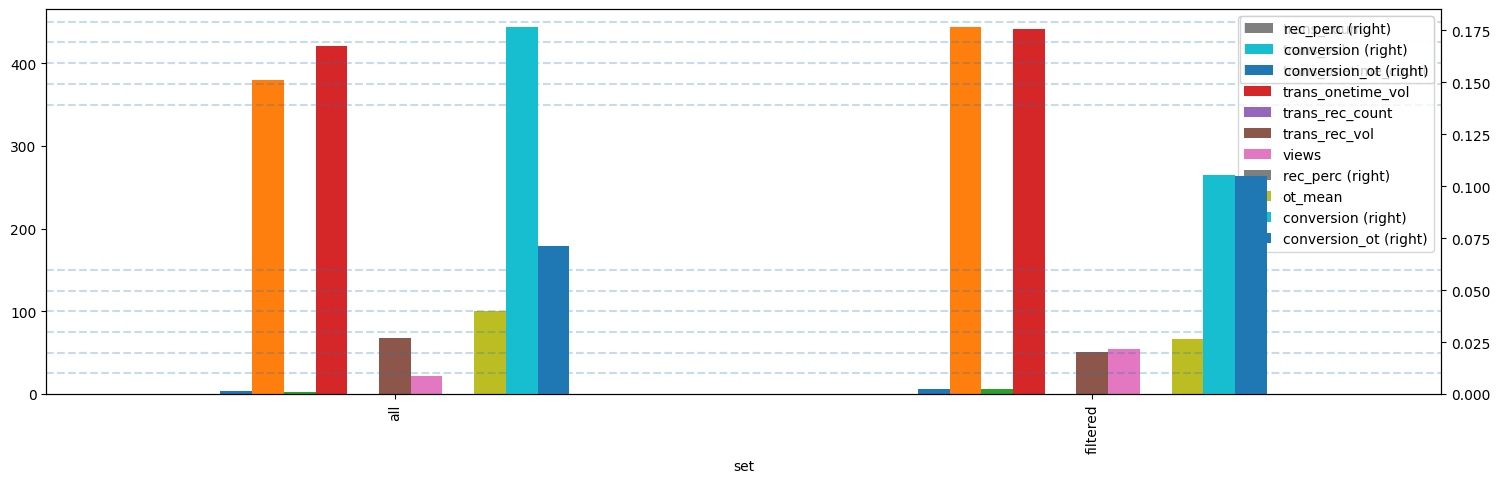

In [171]:
mdns = pd.DataFrame([d_all, d_fltrd])
mdns.set_index('set', inplace=True)

ax = mdns.plot(kind='bar', secondary_y=['ot_perc', 'rec_perc', 'conversion_ot', 'conversion'], figsize=(18,5))
[ax.axhline(i, linestyle='--', alpha=0.25) for i in [25, 50, 75, 100, 125, 150, 350, 375, 400, 425, 450]]
plt.legend(loc='upper right')

In [172]:
for c in itr_cols:
    print("{}:".format(c))
    print("-"*40)
    
    this_min = df[c].replace([np.inf, -np.inf], np.nan).dropna().min()
    this_median = df[c].replace([np.inf, -np.inf], np.nan).dropna().median()
    this_mean = df[c].replace([np.inf, -np.inf], np.nan).dropna().mean()
    this_std = df[c].replace([np.inf, -np.inf], np.nan).dropna().std()
    this_max = df[c].replace([np.inf, -np.inf], np.nan).dropna().max()
    print("All: {:.2f} min; {:.2f} median; {:.2f} mean; {:.2f} std; {:.2f} max".format(this_min, this_median, this_mean, this_std, this_max))
    
    this_min = fltrd[c].replace([np.inf, -np.inf], np.nan).dropna().min()
    this_median = fltrd[c].replace([np.inf, -np.inf], np.nan).dropna().median()
    this_mean = fltrd[c].replace([np.inf, -np.inf], np.nan).dropna().mean()
    this_std = fltrd[c].replace([np.inf, -np.inf], np.nan).dropna().std()
    this_max = fltrd[c].replace([np.inf, -np.inf], np.nan).dropna().max()
    print("Filtered: {:.2f} min; {:.2f} median; {:.2f} mean; {:.2f} std; {:.2f} max".format(this_min, this_median, this_mean, this_std, this_max))
    print()

trans_count:
----------------------------------------
All: 1.00 min; 4.00 median; 16.78 mean; 102.50 std; 29171.00 max
Filtered: 1.00 min; 6.00 median; 15.04 mean; 29.96 std; 1142.00 max

trans_vol:
----------------------------------------
All: 0.00 min; 380.00 median; 2103.69 mean; 9758.64 std; 1750986.23 max
Filtered: 0.00 min; 443.19 median; 1467.86 mean; 3668.74 std; 201294.88 max

trans_onetime_count:
----------------------------------------
All: 0.00 min; 2.00 median; 10.73 mean; 64.58 std; 23638.00 max
Filtered: 0.00 min; 6.00 median; 14.97 mean; 29.91 std; 1142.00 max

trans_onetime_vol:
----------------------------------------
All: 0.00 min; 420.25 median; 2195.67 mean; 9721.84 std; 1726592.57 max
Filtered: 0.00 min; 441.75 median; 1462.74 mean; 3646.00 std; 199994.88 max

trans_rec_count:
----------------------------------------
All: 0.00 min; 0.00 median; 0.39 mean; 7.35 std; 2978.00 max
Filtered: 0.00 min; 0.00 median; 0.02 mean; 0.19 std; 13.00 max

trans_rec_vol:
--------

Percentage chang from all to filtered group


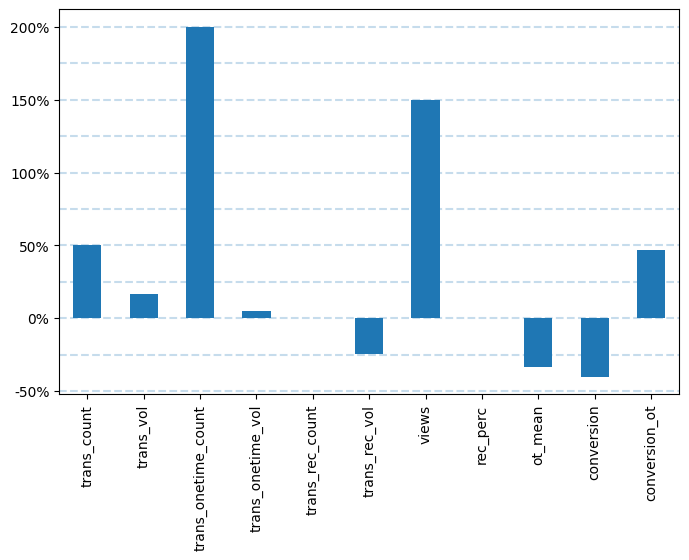

In [173]:
print("Percentage chang from all to filtered group")
ax = (mdns.pct_change() * 100.).iloc[1].plot(kind='bar', figsize=(8,5))

formatter_func = lambda x, pos: f"{int(x)}%"
ax.yaxis.set_major_formatter(formatter_func)

[ax.axhline(i, linestyle='--', alpha=0.25) for i in [-50, -25, 0, 25, 50, 75, 100, 125, 150, 175, 200]]

### form types of filtered set

- 1 qgiv
- 2 political
- 3 p2p
- 5 auction

In [174]:
q = "select id as form, type from form"
form_types = redshift_query_read(q, schema='production')

In [175]:
df = df.merge(form_types, on='form')
fltrd = df[df['form'].isin(intersection)].copy()

In [176]:
print("form type distribution for all observations:")
df['type'].value_counts(normalize=True)

form type distribution for all observations:


1    0.893216
3    0.087976
5    0.018767
2    0.000040
Name: type, dtype: float64

In [177]:
print("form type distribution for filtered forms:")
fltrd['type'].value_counts(normalize=True)

form type distribution for filtered forms:


1    0.690519
3    0.254046
5    0.055435
Name: type, dtype: float64

P2P and auctions are over represented in the filtered set

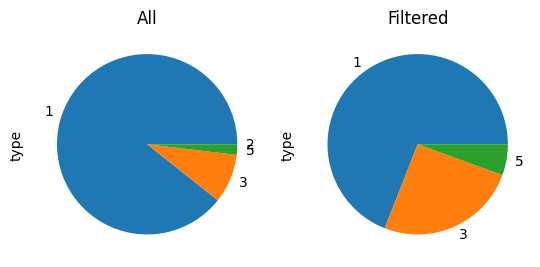

In [178]:
fig, axes = plt.subplots(nrows=1, ncols=2)

fig1 = fltrd['type'].value_counts(normalize=True).plot(kind='pie', title='Filtered', ax=axes[1])
fig2 = df['type'].value_counts(normalize=True).plot(kind='pie', title='All', ax=axes[0])

In [179]:
#pd.DataFrame(fltrd['form'].unique(), columns=['form']).to_csv("filtered_forms.csv", index=False)

### product conversion breakdown

In [180]:
print("One time conversion for all filtered forms observations")

conv_ots = fltrd.groupby('type')['conversion_ot'].describe().reset_index().drop('mean', axis=1)
conv_ots = conv_ots.merge(fltrd.groupby('type')['conversion_ot'].agg(['mean', 'median']).reset_index(), on='type')
conv_ots.merge(fltrd.groupby('type')['form'].nunique().reset_index(), on='type')

One time conversion for all filtered forms observations


,type,count,std,min,25%,50%,75%,max,mean,median,form
0,1,64337.0,1.951666,0.000000,0.037037,0.083333,0.20,241.5,0.343728,0.083333,5893
1,3,23670.0,5.941656,0.000000,0.062500,0.250000,0.75,400.0,1.186185,0.250000,2642
2,5,5165.0,1.404769,0.002488,0.112676,0.333333,0.78,43.5,0.695149,0.333333,995


In [181]:
print("One time conversion for filtered forms excluding observations with more transactions than page views")

_fltrd = fltrd[fltrd['trans_count']<fltrd['views']]
conv_ots = _fltrd.groupby('type')['conversion_ot'].describe().reset_index().drop('mean', axis=1)
conv_ots = conv_ots.merge(_fltrd.groupby('type')['conversion_ot'].agg(['mean', 'median']).reset_index(), on='type')
conv_ots.merge(_fltrd.groupby('type')['form'].nunique().reset_index(), on='type')

One time conversion for filtered forms excluding observations with more transactions than page views


,type,count,std,min,25%,50%,75%,max,mean,median,form
0,1,60288.0,0.158420,0.000000,0.034682,0.076923,0.166667,0.982456,0.133575,0.076923,5856
1,3,18843.0,0.248176,0.000000,0.048468,0.130435,0.400000,0.995633,0.245277,0.130435,2622
2,5,4081.0,0.244960,0.002488,0.081081,0.230769,0.476190,0.987013,0.292529,0.230769,962


## NTEE filtering & representation

In [182]:
q = '''select id as org, segment as ntee from organization'''
orgs_ntees = redshift_query_read(q, schema='production')

In [183]:
q = '''select id as form, org from form'''
form_orgs = redshift_query_read(q, schema='production')

In [184]:
all_ntees = df.merge(form_orgs, on='form').merge(orgs_ntees, on='org')[['form', 'org', 'ntee']].drop_duplicates('org')

print("{:,} rows".format(len(all_ntees)))
all_ntees.head(2)

6,334 rows


,form,org,ntee
0,16,41,Z - Unknown
117,223,243,B - Educational Institutions


In [185]:
fltrd_ntees = fltrd.merge(form_orgs, on='form').merge(orgs_ntees, on='org')[['form', 'org', 'ntee']].drop_duplicates('org')

print("{:,} rows".format(len(fltrd_ntees)))
fltrd_ntees.head(2)

2,834 rows


,form,org,ntee
0,91252,27642,Z - Unknown
5,928015,441545,O - Youth Development


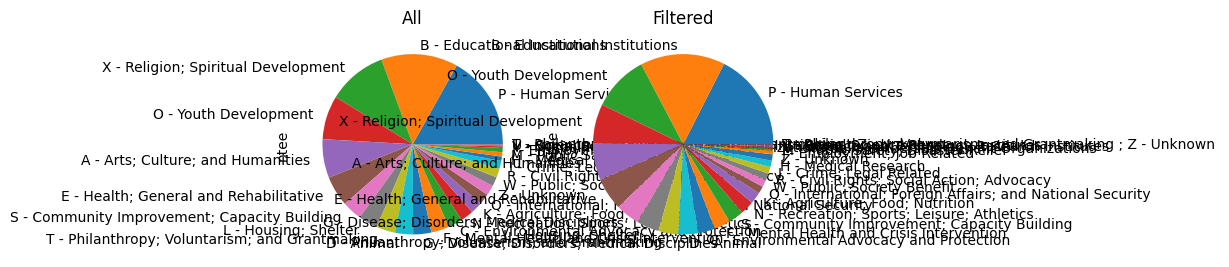

In [186]:
fig, axes = plt.subplots(nrows=1, ncols=2)

fig1 = fltrd_ntees['ntee'].value_counts(normalize=True).plot(kind='pie', title='Filtered', ax=axes[1])
fig2 = all_ntees['ntee'].value_counts(normalize=True).plot(kind='pie', title='All', ax=axes[0])

In [187]:
ntee_dist = fltrd_ntees['ntee'].value_counts(normalize=True).reset_index()
ntee_dist.columns = ['ntee', 'filtered']

ntee_dist_all = all_ntees['ntee'].value_counts(normalize=True).reset_index()
ntee_dist_all.columns = ['ntee', 'all']

ntee_dist.merge(ntee_dist_all, on='ntee')

,ntee,filtered,all
0,P - Human Services,0.175276,0.168862
1,B - Educational Institutions,0.151763,0.137371
2,O - Youth Development,0.100819,0.078406
3,X - Religion; Spiritual Development,0.069825,0.106362
4,A - Arts; Culture; and Humanities,0.066619,0.069248
5,E - Health; General and Rehabilitative,0.058425,0.054467
6,G - Disease; Disorders; Medical Disciplines,0.042394,0.032455
7,L - Housing; Shelter,0.040613,0.034383
8,T - Philanthropy; Voluntarism; and Grantmaking,0.035625,0.033901
9,D - Animal,0.035625,0.032455


## conversion

In [189]:
df.groupby('type')['conversion_ot'].agg(['mean', 'median']).reset_index()

,type,mean,median
0,1,NaN,0.064516
1,2,0.248972,0.090993
2,3,NaN,0.280221
3,5,1.059403,0.250000


In [190]:
df['conversion_ot'].replace([np.inf, -np.inf], np.nan).dropna().describe()

count    543884.000000
mean          0.563949
std           5.921485
min           0.000000
25%           0.012579
50%           0.071429
75%           0.230306
max        2230.500000
Name: conversion_ot, dtype: float64

In [191]:
_df = df[['type', 'conversion_ot']].copy()
_df['conversion_ot'] = _df['conversion_ot'].replace([np.inf, -np.inf], np.nan)
_df.dropna(inplace=True)

In [192]:
conv_agg = _df.groupby('type')['conversion_ot'].agg(['mean', 'median']).reset_index()
conv_agg.columns = ['type', 'all mean', 'all median']

In [193]:
fltrd_conv_agg = fltrd.groupby('type')['conversion_ot'].agg(['mean', 'median']).reset_index()
fltrd_conv_agg.columns = ['type', 'fltrd mean', 'fltrd median']

In [194]:
conv_agg.merge(fltrd_conv_agg, on='type')

,type,all mean,all median,fltrd mean,fltrd median
0,1,0.346846,0.064516,0.343728,0.083333
1,3,2.656457,0.280000,1.186185,0.250000
2,5,1.059403,0.250000,0.695149,0.333333
